In [4]:
library(forecast)
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Aggregated TS

In [5]:
df_eu  <-  read.csv(file="hts_rus_summed.csv", header=TRUE, sep=",", row.names =1 )

In [6]:
gdp_agg <- df_eu_sums <-  rowSums(df_eu)

In [7]:
gdp_agg %>% head()

2006-01-01 2006-02-01 2006-03-01 2006-04-01 2006-05-01 2006-06-01 
    -99636     -67539     -65908     -59589     -68708     -53946

In [10]:
gdp_agg  <- ts(gdp_agg, frequency = 12, start = 2006) 

In [11]:
train <- window(gdp_agg, end=c(2016,12))
test <- window(gdp_agg, start=c(2017,1))

#### Модель 0: RW with drift

The random walk with drift model is

$$Y_t=c + Y_{t-1} + Z_t$$

``rwf(y, h, drift=TRUE)``

#### Модель 1: Theta

``library(foreast)``

Equivalent to simple exponential smoothing with drift 

$\sim$ ETS(AAdN)

In [17]:
gdp_rwf <- rwf(train,h=25)
gdp_rwfwd <- rwf(train,h=25, drift=TRUE)
gdp_snaive  <- snaive(train,h=25)
gdp_theta  <- thetaf(train, h=25)
gdp_arima  <- forecast(Arima(train, order=c(2,1,2), seasonal=c(2,1,2)), h=25)
gdp_auto_arima  <- forecast(auto.arima(train), h=25)
gdp_ets <- forecast(ets(train), h=25)

In [18]:
cat("RW")
accuracy(gdp_rwf, test)[, c(2,5,7,8)]
cat("RW with drift ")
accuracy(gdp_rwfwd, test)[, c(2,5,7,8)]
cat("SNaive")
accuracy(gdp_snaive, test)[, c(2,5,7,8)]
# cat("Theta")
# accuracy(gdp_theta, test)[, c(2,5,7,8)]
cat("ARIMA")
accuracy(gdp_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA")
accuracy(gdp_auto_arima, test)[, c(2,5,7,8)]
cat("ETS")
accuracy(gdp_ets, test)[, c(2,5,7,8)]

RW

,RMSE,MAPE,ACF1,Theil's U
Training set,11531.02,469.0393,-0.1421609,NA
Test set,14204.25,141.4812,0.5640063,1.361271


RW with drift 

,RMSE,MAPE,ACF1,Theil's U
Training set,11512.12,444.34626,-0.1421609,NA
Test set,18894.72,97.12677,0.6173133,1.080711


SNaive

,RMSE,MAPE,ACF1,Theil's U
Training set,11615.18,575.7678,0.6010402,NA
Test set,17261.85,195.7287,0.6831908,1.950867


ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,5735.156,344.1934,-0.04016493,NA
Test set,16288.313,189.8155,0.68127627,2.451983


Auto ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,5867.315,308.5038,-0.04644988,NA
Test set,15320.535,179.1187,0.65623722,2.302041


ETS

,RMSE,MAPE,ACF1,Theil's U
Training set,5638.747,148.3019,0.1408629,NA
Test set,10980.156,106.1166,0.5549177,1.544246


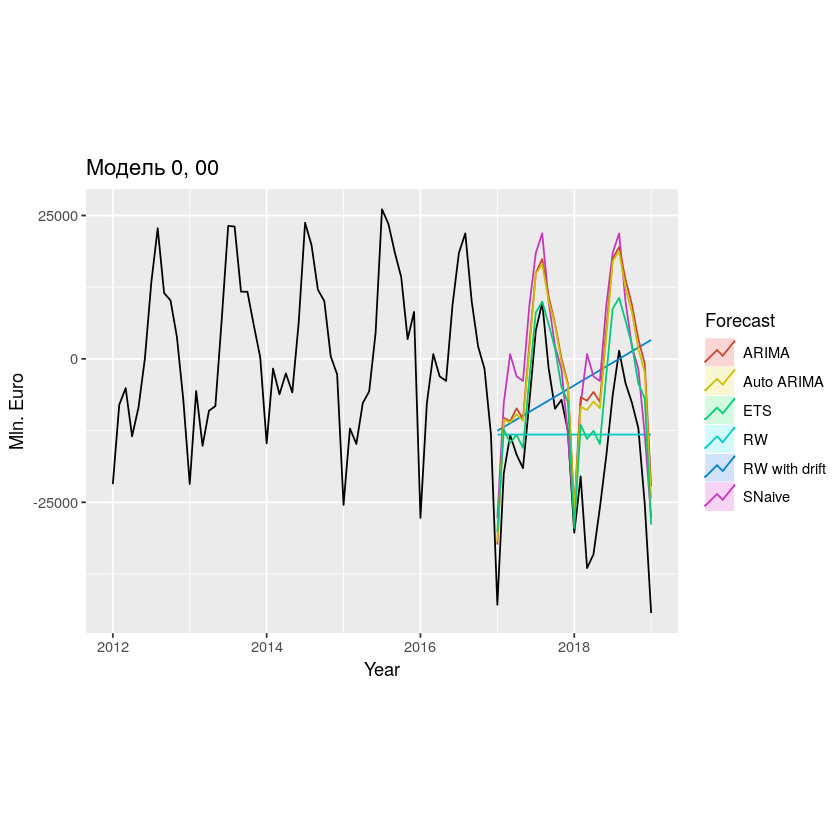

In [19]:
autoplot(window(gdp_agg, start=2012)) +
    autolayer(gdp_rwf, series="RW", PI=FALSE) +
    autolayer(gdp_rwfwd, series="RW with drift", PI=FALSE) +
    autolayer(gdp_snaive, series="SNaive", PI=FALSE) +
#     autolayer(gdp_theta, series="Theta Method", PI=FALSE) +
    autolayer(gdp_arima, series="ARIMA", PI=FALSE) +
    autolayer(gdp_auto_arima, series="Auto ARIMA", PI=FALSE) +
    autolayer(gdp_ets, series="ETS", PI=FALSE) +
    xlab("Year") + ylab("Mln. Euro") +
    ggtitle("Модель 0, 00") +
    guides(colour=guide_legend(title="Forecast")) +
    theme(aspect.ratio = 0.75)

### strucchange

In [20]:
library(strucchange)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich



	 Optimal 2-segment partition: 

Call:
breakpoints.Fstats(obj = fs.gdp_agg)

Breakpoints at observation number:
83 

Corresponding to breakdates:
2012(11) 

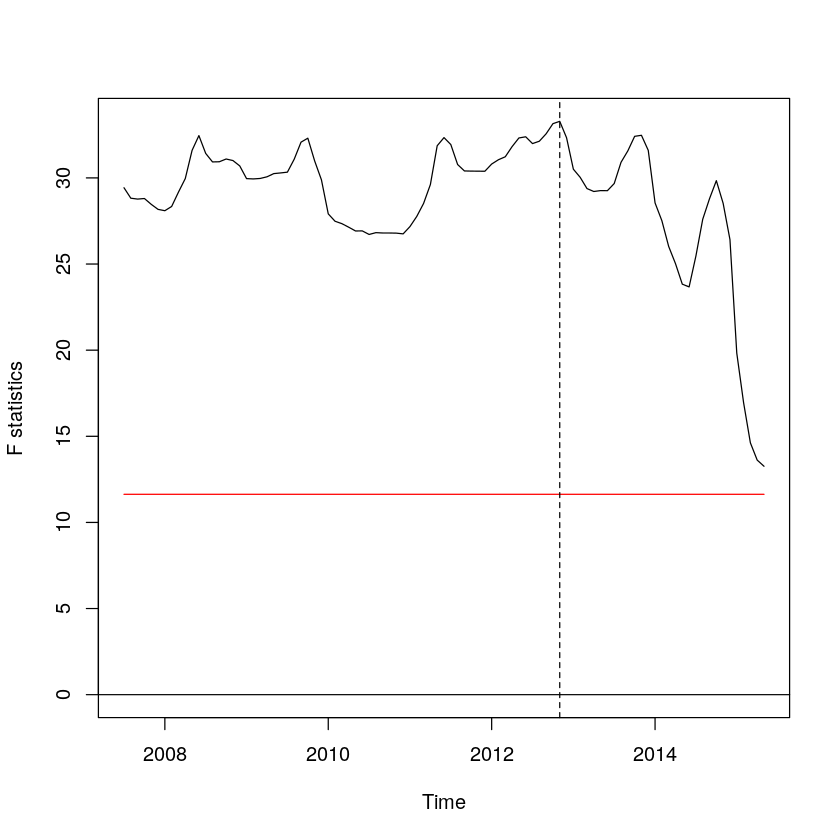

In [21]:
## F statistics indicate one breakpoint
fs.gdp_agg <- Fstats(train  ~  1 + time(train))
plot(fs.gdp_agg)
breakpoints(fs.gdp_agg)
lines(breakpoints(fs.gdp_agg))

In [20]:
breakpoints(fs.gdp_agg)[[1]] 

[1] 36

In [21]:
dum  <-  rep(c(0,1), c(breakpoints(fs.gdp_agg)[[1]], length(gdp_agg) - breakpoints(fs.gdp_agg)[[1]]))
dum2  <-  rep(c(0,1), c(36,length(gdp_agg)-36))

In [22]:
all(dum == dum2)

[1] TRUE

https://www.stat.ncsu.edu/people/bloomfield/courses/st730/slides/R-comments.pdf

In [23]:
library(zoo)

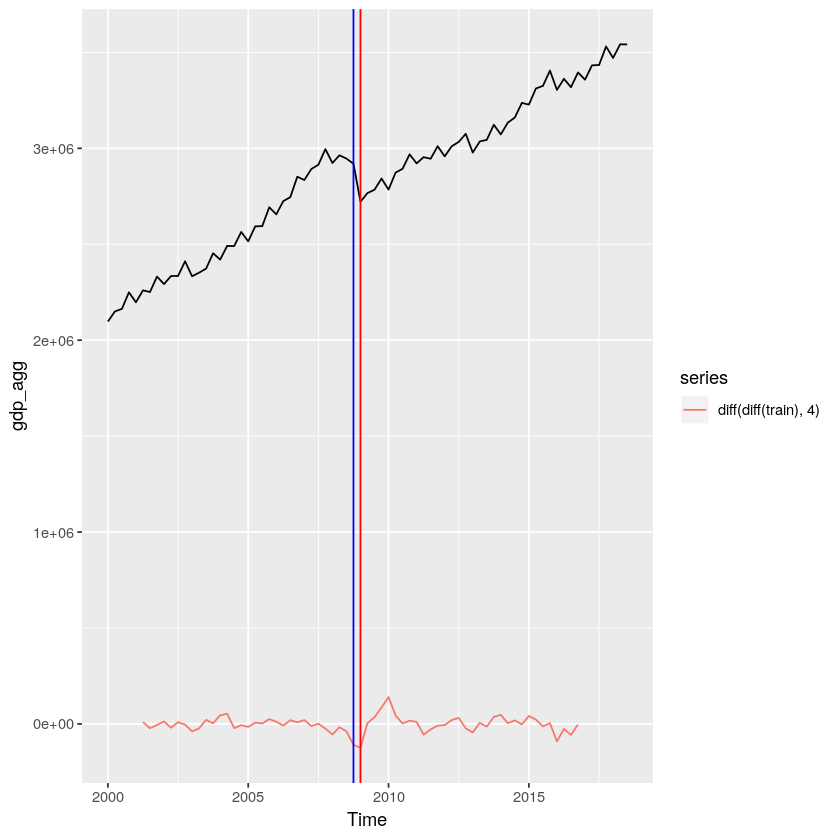

In [24]:
autoplot(gdp_agg) +
    autolayer(diff(diff(train),4)) + 
    geom_vline(xintercept=c(time(gdp_agg)[breakpoints(fs.gdp_agg)[[1]]],time(gdp_agg)[37]), col=c("blue", "red"))

In [25]:
auto.arima(gdp_agg, lambda = 'auto', xreg=dum)

Series: gdp_agg 
Regression with ARIMA(1,1,0)(1,0,0)[4] errors 
Box Cox transformation: lambda= 0.48701 

Coefficients:
         ar1    sar1      xreg
      0.3343  0.9119  -48.8650
s.e.  0.1270  0.0434   11.2794

sigma^2 estimated as 213.4:  log likelihood=-305.53
AIC=619.05   AICc=619.63   BIC=628.27

In [26]:
auto.arima(train)
auto.arima(train, lambda = 'auto', xreg=dum[1:68])
auto.arima(train, lambda = 'auto', xreg=dum2[1:68])

Series: train 
ARIMA(2,0,0)(2,1,0)[4] with drift 

Coefficients:
         ar1      ar2     sar1     sar2      drift
      1.4235  -0.5655  -0.3083  -0.4719  18140.750
s.e.  0.0987   0.1006   0.1399   0.1145   3356.515

sigma^2 estimated as 779254753:  log likelihood=-745.74
AIC=1503.48   AICc=1504.95   BIC=1516.43

Series: train 
Regression with ARIMA(1,1,0)(2,0,0)[4] errors 
Box Cox transformation: lambda= 0.8985424 

Coefficients:
         ar1    sar1    sar2        xreg
      0.3387  0.5819  0.3629  -25175.140
s.e.  0.1317  0.1281  0.1308    5596.726

sigma^2 estimated as 40829929:  log likelihood=-684.31
AIC=1378.63   AICc=1379.61   BIC=1389.65

Series: train 
Regression with ARIMA(1,1,0)(2,0,0)[4] errors 
Box Cox transformation: lambda= 0.8985424 

Coefficients:
         ar1    sar1    sar2        xreg
      0.3387  0.5819  0.3629  -25175.140
s.e.  0.1317  0.1281  0.1308    5596.726

sigma^2 estimated as 40829929:  log likelihood=-684.31
AIC=1378.63   AICc=1379.61   BIC=1389.65

In [27]:
gdp_rwfwd <- rwf(train,h=7, drift=TRUE)
gdp_snaive  <- snaive(train,h=7)
gdp_theta  <- thetaf(train, h=7)
gdp_arima  <- forecast(Arima(train, order=c(2,1,2), seasonal=c(2,1,2)), h=7)
gdp_auto_arima  <- forecast(auto.arima(train), h=7)
gdp_str_arima  <- forecast(auto.arima(train, lambda = 'auto', xreg=dum[1:68]), 7, xreg = dum[69:75])
gdp_str2_arima  <-  forecast(auto.arima(train, lambda = 'auto', xreg=dum2[1:68]), 7, xreg = dum2[69:75])
gdp_str3_arima  <- forecast(Arima(train, order=c(2,1,2), seasonal=c(2,1,2), xreg=dum2[1:68]), h=7, xreg = dum2[69:75])

cat("RW with drift ")
accuracy(gdp_rwfwd, test)[, c(2,5,7,8)]
cat("Theta")
accuracy(gdp_theta, test)[, c(2,5,7,8)]
cat("ARIMA")
accuracy(gdp_arima, test)[, c(2,5,7,8)]
cat("ARIMA 2009")
accuracy(gdp_str3_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA")
accuracy(gdp_auto_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA str")
accuracy(gdp_str_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA 2009")
accuracy(gdp_str2_arima, test)[, c(2,5,7,8)]


Warning message in forecast.Arima(Arima(train, order = c(2, 1, 2), seasonal = c(2, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”

RW with drift 

,RMSE,MAPE,ACF1,Theil's U
Training set,58849.27,1.7150060,-0.4830031,NA
Test set,34776.71,0.8161775,-0.3038002,0.4691468


Theta

,RMSE,MAPE,ACF1,Theil's U
Training set,35986.47,1.041397,0.3294760,NA
Test set,109496.60,2.960996,0.6189463,1.829338


ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,21785.78,0.5747027,0.07492727,NA
Test set,67549.13,1.8853066,0.20566073,1.124845


ARIMA 2009

,RMSE,MAPE,ACF1,Theil's U
Training set,20664.46,0.5171513,-0.016175671,NA
Test set,60599.20,1.6938699,-0.007325357,1.014394


Auto ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,26002.27,0.7027395,0.01000688,NA
Test set,73355.31,2.0782801,0.34890538,1.210819


Auto ARIMA str

,RMSE,MAPE,ACF1,Theil's U
Training set,27834.33,0.7382768,-0.04103613,NA
Test set,81958.28,2.1087837,0.55341056,1.379567


Auto ARIMA 2009

,RMSE,MAPE,ACF1,Theil's U
Training set,27834.33,0.7382768,-0.04103613,NA
Test set,81958.28,2.1087837,0.55341056,1.379567


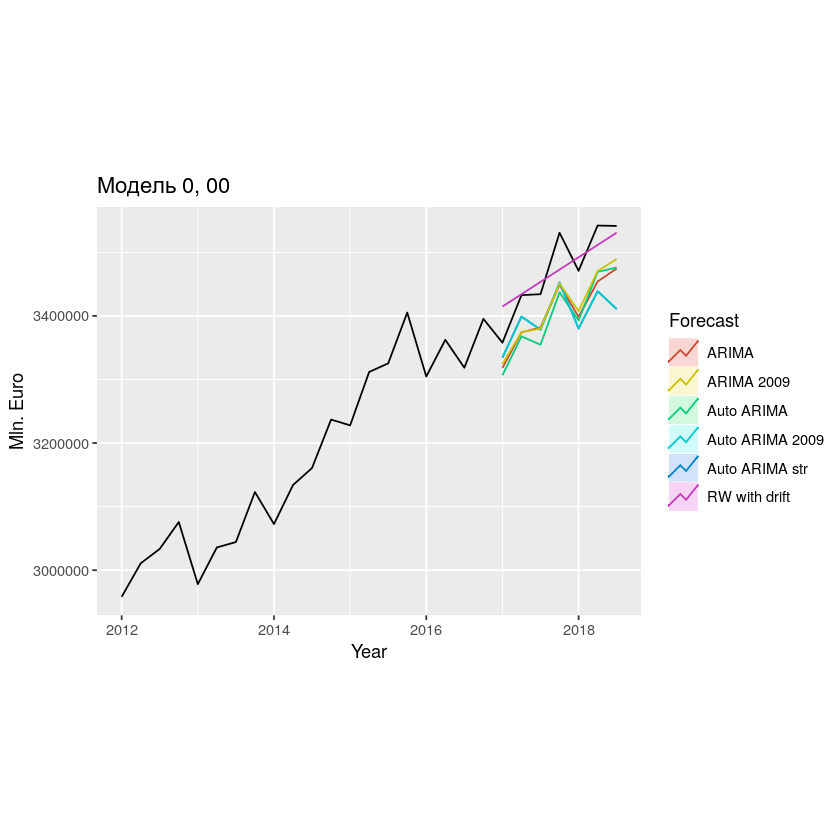

In [28]:
autoplot(window(gdp_agg, start=2012)) +
    autolayer(gdp_rwfwd, series="RW with drift", PI=FALSE) +
    autolayer(gdp_arima, series="ARIMA", PI=FALSE) +
    autolayer(gdp_auto_arima, series="Auto ARIMA", PI=FALSE) +
    autolayer(gdp_str_arima, series="Auto ARIMA str", PI=FALSE) +
    autolayer(gdp_str2_arima, series="Auto ARIMA 2009", PI=FALSE) +
    autolayer(gdp_str3_arima, series="ARIMA 2009", PI=FALSE) +
    xlab("Year") + ylab("Mln. Euro") +
    ggtitle("Модель 0, 00") +
    guides(colour=guide_legend(title="Forecast")) +
    theme(aspect.ratio = 0.75)